<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/vegetables/vegetables_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vegetable Classification
[Original Kaggle Notebook](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)

* Classify 15 different types of vegetables using transfer learning. 

# Import data and helper documents

In [1]:
import tensorflow as tf
import os 


In [2]:
list_dir = os.listdir('.')

if 'vegetable-images.zip?dl=0' not in list_dir:
  # fetch images
  !wget https://www.dropbox.com/s/lbqzfovdqs02nr8/vegetable-images.zip?dl=0
  # fetch helper documents
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-06-04 17:44:10--  https://www.dropbox.com/s/lbqzfovdqs02nr8/vegetable-images.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lbqzfovdqs02nr8/vegetable-images.zip [following]
--2022-06-04 17:44:11--  https://www.dropbox.com/s/raw/lbqzfovdqs02nr8/vegetable-images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad00621c5c9a0b5ad039b3ef1c.dl.dropboxusercontent.com/cd/0/inline/BmmY15PsaaoqHsQr4ZYYPcF-OjnJ1E6f693YoDKBPGTE6U281o8zoz-pGh9r3KsER3ret09DE1AcZJPmPMdc3VIy4e4GJ64dU8Q1Bhw0ERwDqwepWctfZI8luGWxDVme8gIErs44VsLzQhz4X10UrBzvJx1B-_j5pFywixQI0895VA/file# [following]
--2022-06-04 17:44:11--  https://ucad00621c5c9a0b5ad039b3ef1c.dl.dropboxusercontent.com/cd/0/inline/BmmY15PsaaoqHsQr4ZYYPcF-OjnJ1E6f693YoDK

In [68]:
# Let's create a function tgo compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History Objects
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  
  total_val_acc = val_acc + new_history.history['val_accuracy'] 
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Trainig Acc')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  # Make plot for loss
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Trainig Loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')



  

  

In [3]:
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir

In [4]:

dir_list = os.listdir('.')

# unzip data if docs don't exist yet
if 'train_30' not in dir_list:
  unzip_data('vegetable-images.zip?dl=0')

In [5]:
# Check some of the directories
walk_through_dir('validation')

There are 15 directories and 0 images in 'validation'.
There are 0 directories and 200 images in 'validation/Cucumber'.
There are 0 directories and 200 images in 'validation/Carrot'.
There are 0 directories and 200 images in 'validation/Potato'.
There are 0 directories and 200 images in 'validation/Broccoli'.
There are 0 directories and 200 images in 'validation/Brinjal'.
There are 0 directories and 200 images in 'validation/Radish'.
There are 0 directories and 200 images in 'validation/Capsicum'.
There are 0 directories and 200 images in 'validation/Bottle_Gourd'.
There are 0 directories and 200 images in 'validation/Tomato'.
There are 0 directories and 200 images in 'validation/Bitter_Gourd'.
There are 0 directories and 200 images in 'validation/Cabbage'.
There are 0 directories and 200 images in 'validation/Bean'.
There are 0 directories and 200 images in 'validation/Papaya'.
There are 0 directories and 200 images in 'validation/Cauliflower'.
There are 0 directories and 200 images i

# Preprocess data

Lets setup our images and create functions to create new models with the same architecture


## Create image datasets from directories

In [6]:


train_30_percent = tf.keras.preprocessing.image_dataset_from_directory(
  'train_30',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  'train',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  'test',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  'validation',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

Found 4500 files belonging to 15 classes.
Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Create data augmentation layer

In [7]:
data_augmentation_dial = 0.2
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomZoom(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomHeight(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomWidth(data_augmentation_dial),
  # tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
], name='data_augmentation_layer')

## Create function to visualize images (normal/augmented)

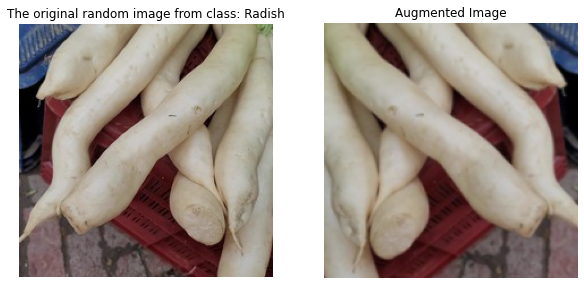

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Set random states
# random.seed(42)
# tf.random.set_seed(42)

def view_random_image():
  target_class = random.choice(train_data.class_names)
  target_dir = 'train/' + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + '/' + random_image

  plt.figure(figsize=(10,15))

  # Read in random image
  image = mpimg.imread(random_image_path)
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title(f'The original random image from class: {target_class}')
  plt.axis(False)


  # Now plot the augmented random image
  augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
  plt.subplot(1, 2, 2)
  plt.imshow(tf.squeeze(augmented_image/255.))
  plt.title(f'Augmented Image')
  plt.axis(False)

view_random_image()

## Creating checkpoint callback


In [23]:
checkpoint_path = 'vegetables_checkpoint_30_percent/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

# Create Feature Extraction models



## Feature Extraction base model

In [50]:
from numpy import e
from tensorflow.keras import layers


# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Extract features from model
x = layers.GlobalAveragePooling2D (name='global_average_pooling_layer')(x)

outputs = layers.Dense(15, activation='softmax', name='output_layer')(x)




## Model 1: Feature Extraction

Epoch 1/5
141/141 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.8742
Epoch 1: val_loss improved from inf to 0.17694, saving model to vegetables_checkpoint_3_percent/checkpoint.ckpt
INFO:tensorflow:Assets written to: vegetables_checkpoint_3_percent/checkpoint.ckpt/assets
141/141 [==============================] - 57s 371ms/step - loss: 0.6956 - accuracy: 0.8742 - val_loss: 0.1769 - val_accuracy: 0.9770
Epoch 2/5
141/141 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9773
Epoch 2: val_loss improved from 0.17694 to 0.08954, saving model to vegetables_checkpoint_3_percent/checkpoint.ckpt
INFO:tensorflow:Assets written to: vegetables_checkpoint_3_percent/checkpoint.ckpt/assets
141/141 [==============================] - 51s 362ms/step - loss: 0.1468 - accuracy: 0.9773 - val_loss: 0.0895 - val_accuracy: 0.9890
Epoch 3/5
141/141 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9838
Epoch 3: val_loss improved from 0.08954

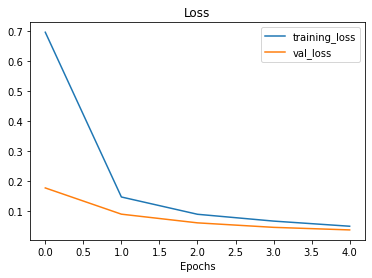

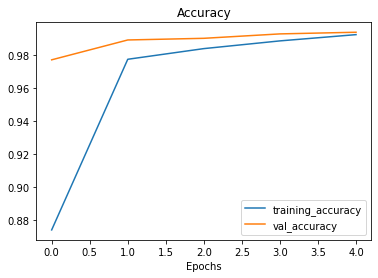

In [25]:

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])



initial_epochs = 5
history_1 = model_1.fit(
    train_30_percent, 
    epochs = initial_epochs,
    steps_per_epoch=len(train_30_percent),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[checkpoint_callback]
)
plot_loss_curves(history_1)

In [26]:
model_1_results = model_1.evaluate(test_data)

94/94 [==============================] - 5s 52ms/step - loss: 0.0411 - accuracy: 0.9930


* model_1 gives great results with 99% accuracy on the full test dataset
* model_1 only uses 30% of training data, we'll use the full training set once we fine tune the model

Since model_1 has good performance we'll checkpoint it to create the fine tuned models to squeeze a little more out of our model

## Model 2: Fine tuning


In [59]:
# Load in the model
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)


### Unfreeze layers

In [62]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)



In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

## Fit the model

Epoch 5/10
94/94 [==============================] - 19s 137ms/step - loss: 0.2264 - accuracy: 0.9413 - val_loss: 0.0876 - val_accuracy: 0.9777
Epoch 6/10
94/94 [==============================] - 11s 121ms/step - loss: 0.0546 - accuracy: 0.9827 - val_loss: 0.0371 - val_accuracy: 0.9883
Epoch 7/10
94/94 [==============================] - 11s 120ms/step - loss: 0.0276 - accuracy: 0.9910 - val_loss: 0.0219 - val_accuracy: 0.9930
Epoch 8/10
94/94 [==============================] - 11s 117ms/step - loss: 0.0076 - accuracy: 0.9967 - val_loss: 0.0284 - val_accuracy: 0.9933
Epoch 9/10
94/94 [==============================] - 11s 119ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.0216 - val_accuracy: 0.9947
Epoch 10/10
94/94 [==============================] - 12s 123ms/step - loss: 0.0084 - accuracy: 0.9970 - val_loss: 0.0179 - val_accuracy: 0.9957


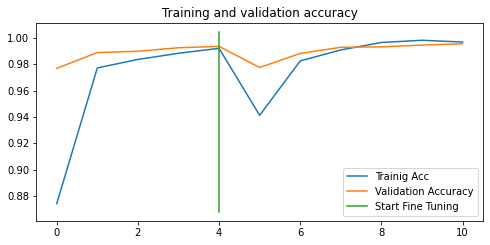

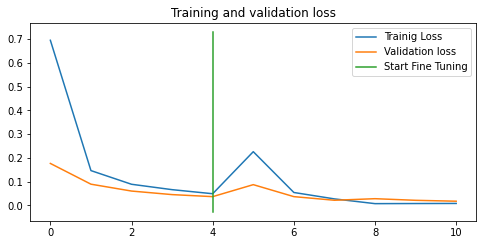

In [69]:

fine_tuned_epochs = initial_epochs + 5

history_2 = model_2.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_2)

In [70]:
model_2_results = model_2.evaluate(test_data)

94/94 [==============================] - 5s 53ms/step - loss: 0.0049 - accuracy: 0.9983


[0.0049196030013263226, 0.9983333349227905]

In [71]:
model_1_results, model_2_results

([0.04111706465482712, 0.9929999709129333],
 [0.0049196030013263226, 0.9983333349227905])

* unfreezing some layers gave us a higher percentage although it's already high from model_1

lets try one more time and we'll unfreeze more layers (30)

## Model 3: Unfreeze more layers

In [72]:
model_3 = tf.keras.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

In [80]:
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_3.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


### Fit the model


Epoch 5/10
94/94 [==============================] - 19s 140ms/step - loss: 0.0364 - accuracy: 0.9903 - val_loss: 0.0205 - val_accuracy: 0.9933
Epoch 6/10
94/94 [==============================] - 12s 125ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 7/10
94/94 [==============================] - 12s 126ms/step - loss: 0.0079 - accuracy: 0.9983 - val_loss: 0.0061 - val_accuracy: 0.9980
Epoch 8/10
94/94 [==============================] - 11s 121ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.0078 - val_accuracy: 0.9973
Epoch 9/10
94/94 [==============================] - 12s 122ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0147 - val_accuracy: 0.9937
Epoch 10/10
94/94 [==============================] - 12s 122ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0071 - val_accuracy: 0.9977


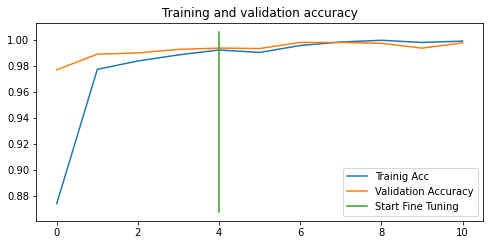

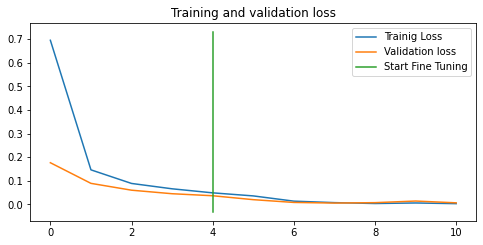

In [82]:
fine_tuned_epochs = initial_epochs + 5

history_3 = model_3.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_3)

In [83]:
model_3_results = model_3.evaluate(test_data)

94/94 [==============================] - 5s 52ms/step - loss: 0.0029 - accuracy: 0.9990


# Compare Models

In [87]:
import pandas as pd
results = [model_1_results , model_2_results, model_3_results]
results_pd = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_pd

,loss,accuracy
0,0.041117,0.993000
1,0.004920,0.998333
2,0.002866,0.999000


# Summary

from the start `EfficientNetB0` habe us a very high score with only 30% of the traning data_augmentation

`model_3` gives us the best accuracy score with 30 layers of the base model unfrozen and re-fitted on our custom data

In [88]:
model_3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 15)                19215     
                                                                 
Total params: 4,068,786
Trainable params: 1,515,375
Non-tra